***
__Tóm tắt Data Mining__
***
- Môn: Kho dữ liệu và OLAP
- Class: IS217.O21.HTCL
- Mô hình sử dụng: __DecisionTree__ và __RandomForest__
- Tỉ lệ train-test: 7:3
***

In [1]:
# Libraries for calculation
import pandas as pd 
import numpy as np 
# Libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Libraries for evaluation
from sklearn import metrics
from sklearn.tree import export_text
from xgboost import plot_tree
# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the data
data = pd.read_csv("C:/Users/dippe/OneDrive/Desktop/Datawarehouse and OLAP Final Project/data/updated_student_data.csv")
data.head()

,school,sex,age,city,state,region,famsize,Pstatus,Medu,Fedu,...,goout,Dalc,Walc,health,absences,G1,G2,G3,finalgrade,ispass
0,GP,F,18,Ribeira Grande,Azores,Norte,GT3,A,4,4,...,4,1,1,3,4,0,11,11,B+,1
1,GP,F,17,Braga,Braga,Norte,GT3,T,1,1,...,3,1,1,3,2,9,11,11,B+,1
2,GP,F,15,Ribeira Grande,Azores,Norte,LE3,T,1,1,...,2,2,3,3,6,12,13,12,A-,1
3,GP,F,15,Aveiro,Aveiro,Centro,GT3,T,4,2,...,2,1,1,5,0,14,14,14,A,1
4,GP,F,16,Ribeira Grande,Azores,Norte,GT3,T,3,3,...,2,1,2,5,0,11,13,13,A,1


***
__Mô hình DecisionTree__
***

In [3]:
# Choose specific columns as independent variables
columns = ['Medu','Fedu','traveltime','studytime','failures','schoolsup','famsup','paid','activities','nursery','higher',
            'internet','romantic','famrel','freetime','goout','Dalc','Walc','health','absences','G1','G2']
X_train, X_test, y_train, y_test = train_test_split(data[columns], data['ispass'], test_size=0.3, random_state=42)
# Create and fit model
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

***
Find features using __Permutation Feature Importance__
***

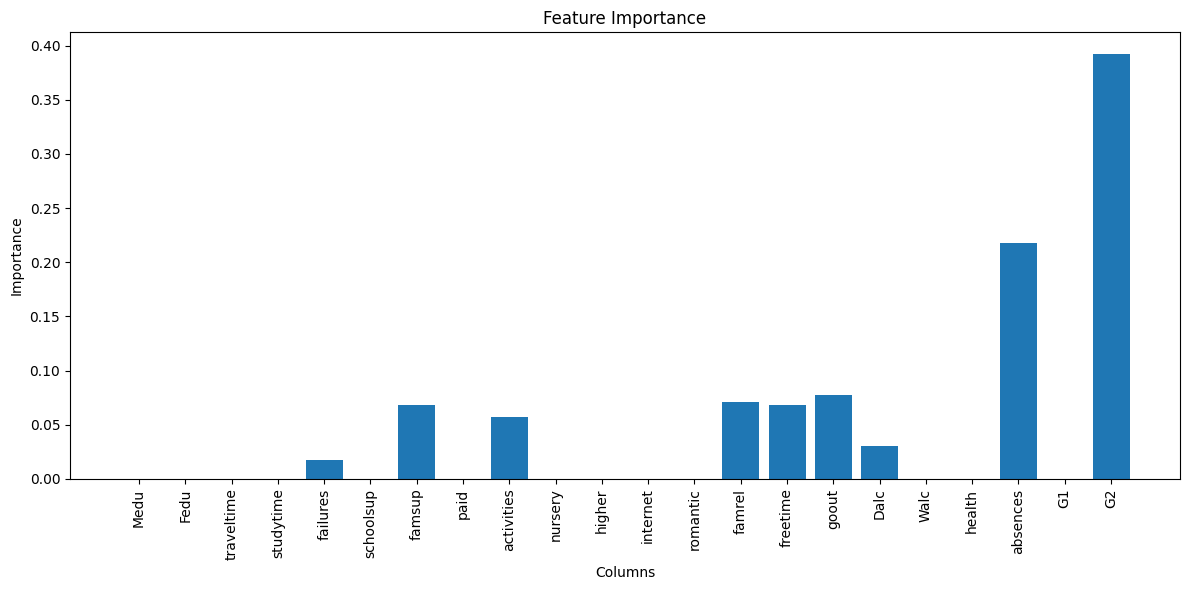

In [4]:
# Get importance
importance = model.feature_importances_
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(columns)), importance, align='center')
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlabel('Columns')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()  # Adjust layout to fit the labels
plt.savefig("feature_importance.png")
plt.show()

Từ biểu đồ, ta chọn 2 features có ảnh hưởng nhiều nhất là absences(0.21) và G2(0.39)

In [5]:
# Choose the best features
features = ['absences','G2']
# Resplit train and test data
X_train, X_test, y_train, y_test = train_test_split(data[features], data['ispass'], test_size=0.3, random_state=42)

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [6]:
# Predict using test data
y_pred = model.predict(X_test)
# Evaluate the model
tree_score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', tree_score)

Accuracy: 0.9846153846153847


In [7]:
# Find model confusion matrix
tree_cm = metrics.confusion_matrix(y_test, y_pred)

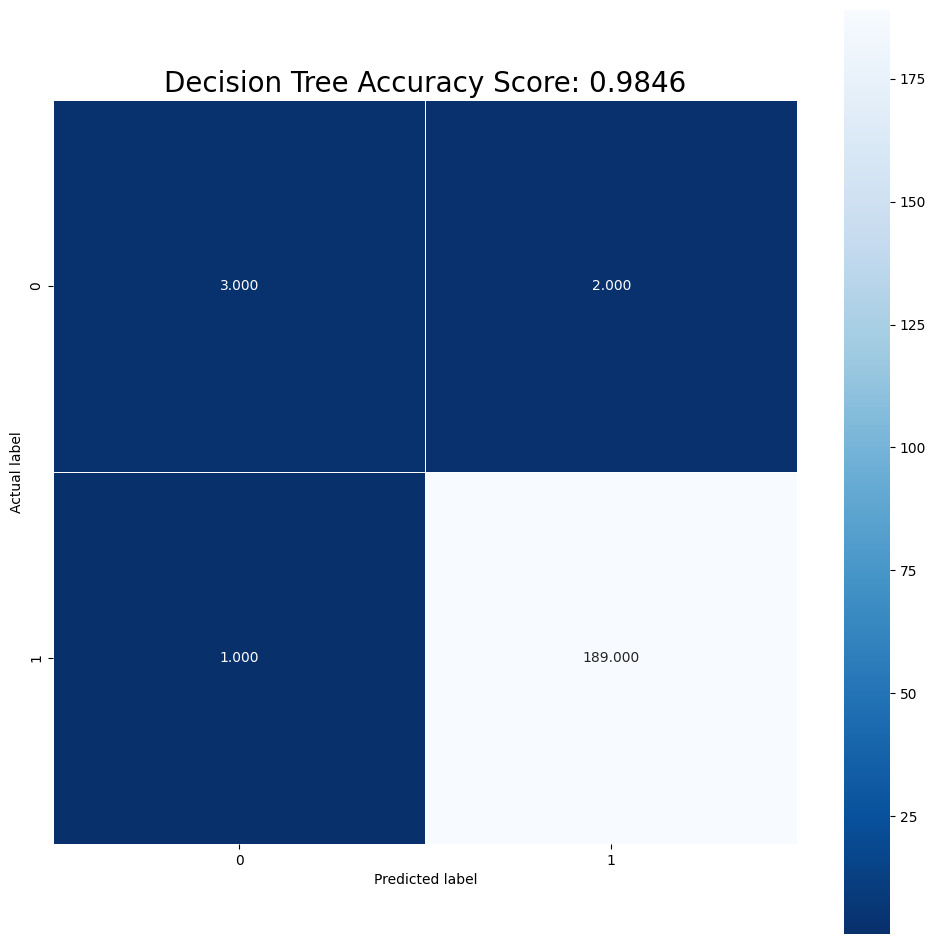

In [8]:
# Show heatmap
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Decision Tree Accuracy Score: {0}'.format(round(tree_score,4))
plt.title(title, size = 20)
plt.savefig("cm_decisiontree.png")

__Upsampling Minority Class__

In [9]:
df = pd.concat([X_train, y_train], axis=1)

df_majority = df[df.ispass==1]
print(len(df_majority))
df_minority = df[df.ispass==0]
print(len(df_minority))

df_minority_upsampled = resample(df_minority, replace=True, n_samples=int(len(df_majority)), random_state=1234)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['ispass'].value_counts()

442
12


1    442
0    442
Name: ispass, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled[features], df_upsampled['ispass'], test_size=0.3, random_state=42)

model2 = tree.DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [11]:
# Predict using test data
y_pred = model.predict(X_test)
# Evaluate the model
tree_score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', tree_score)

Accuracy: 0.8345864661654135


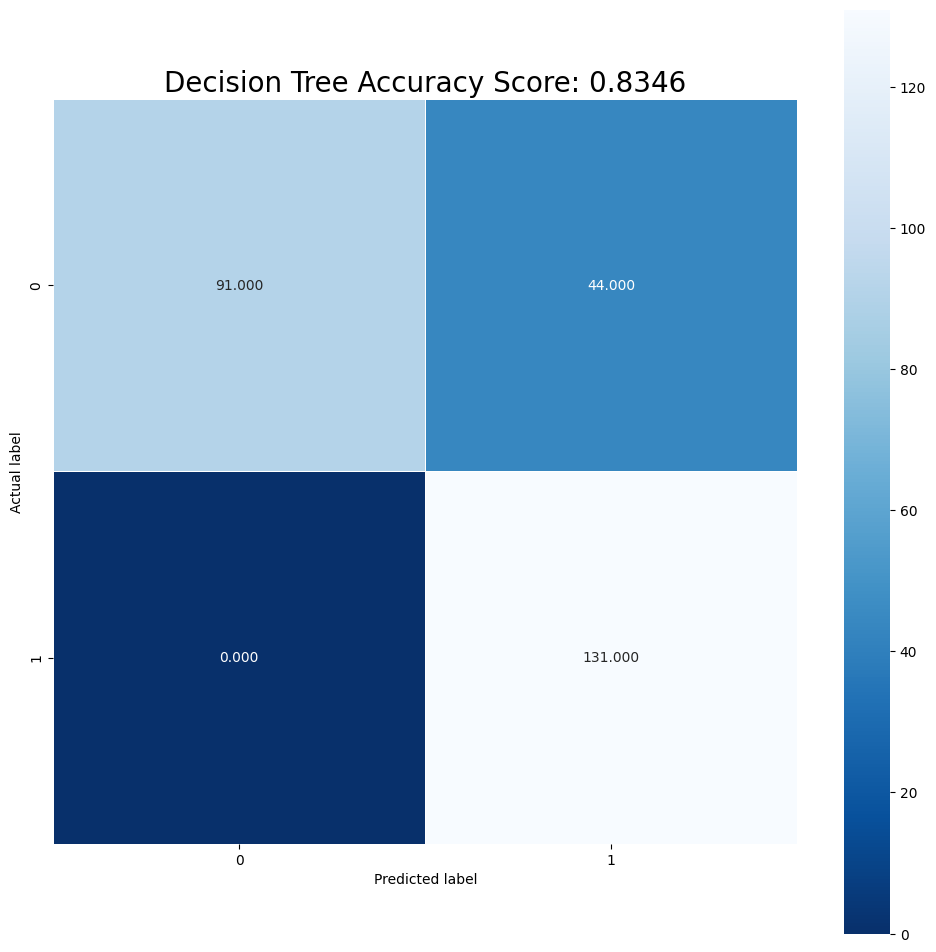

In [12]:
# Find model confusion matrix
tree_cm = metrics.confusion_matrix(y_test, y_pred)

# Show heatmap
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Decision Tree Accuracy Score: {0}'.format(round(tree_score,4))
plt.title(title, size = 20)
plt.savefig("cm_decisiontree2.png")

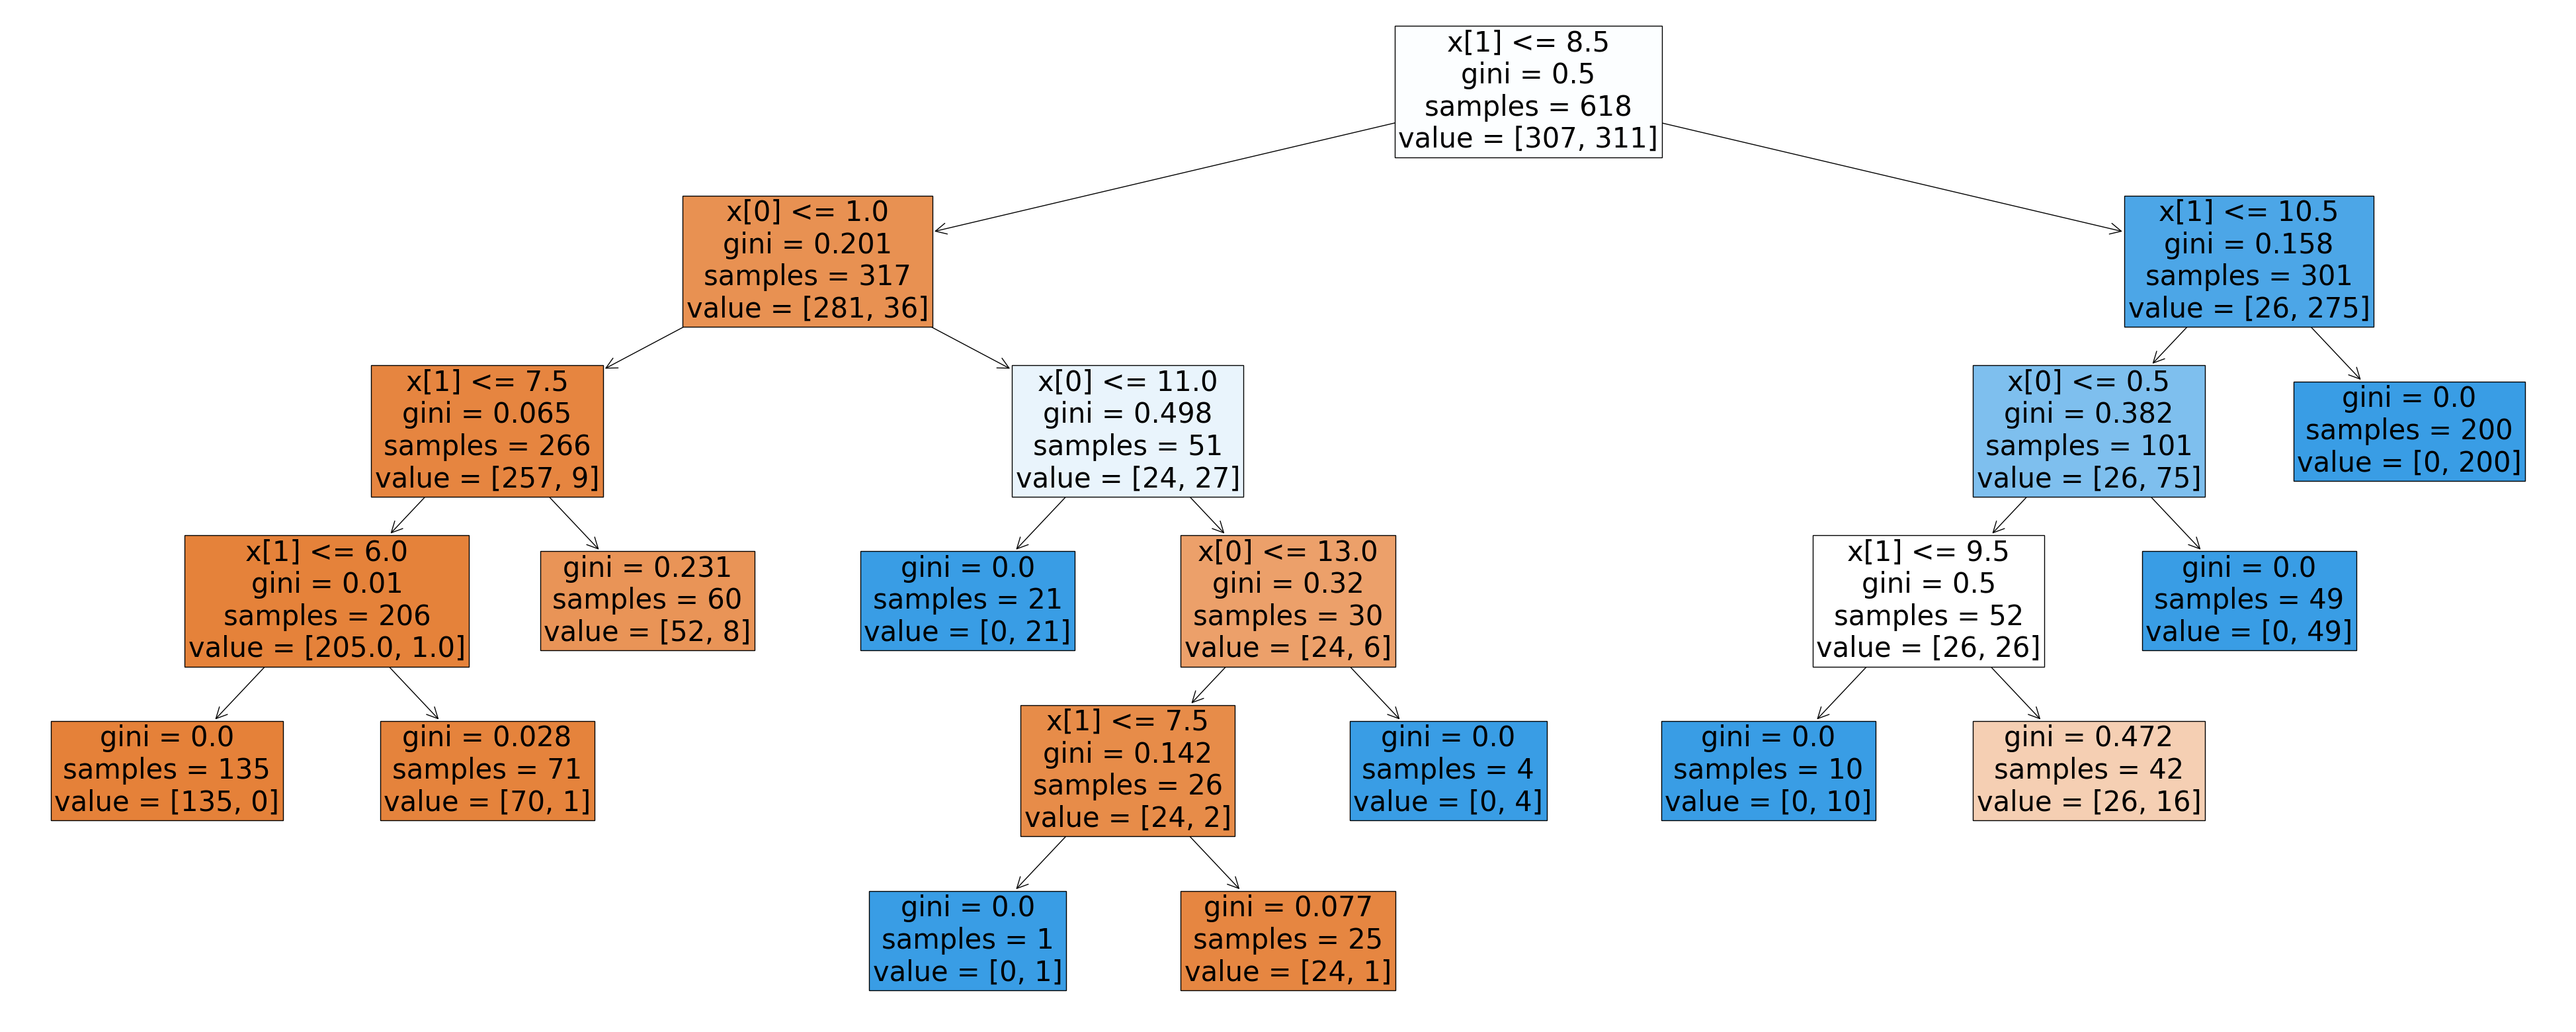

In [13]:
# Show ID3 tree
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(model2, filled=True, fontsize=30)
plt.savefig('decision_tree.png', dpi=100)
plt.show()

In [14]:
# Show detailed ID3
rules = export_text(model2, feature_names=features)
print(rules)

|--- G2 <= 8.50
|   |--- absences <= 1.00
|   |   |--- G2 <= 7.50
|   |   |   |--- G2 <= 6.00
|   |   |   |   |--- class: 0
|   |   |   |--- G2 >  6.00
|   |   |   |   |--- class: 0
|   |   |--- G2 >  7.50
|   |   |   |--- class: 0
|   |--- absences >  1.00
|   |   |--- absences <= 11.00
|   |   |   |--- class: 1
|   |   |--- absences >  11.00
|   |   |   |--- absences <= 13.00
|   |   |   |   |--- G2 <= 7.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- G2 >  7.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- absences >  13.00
|   |   |   |   |--- class: 1
|--- G2 >  8.50
|   |--- G2 <= 10.50
|   |   |--- absences <= 0.50
|   |   |   |--- G2 <= 9.50
|   |   |   |   |--- class: 1
|   |   |   |--- G2 >  9.50
|   |   |   |   |--- class: 0
|   |   |--- absences >  0.50
|   |   |   |--- class: 1
|   |--- G2 >  10.50
|   |   |--- class: 1



In [15]:
# Create new data to predict
new_data = {
    'absences': 7,
    'G2': 6
}
new_data = pd.DataFrame([new_data])
# Prediction
predicted = model.predict(new_data)
print('Học sinh có đậu môn hay không:', 'Yes' if predicted == 1 else 'No')

Học sinh có đậu môn hay không: Yes


***
__Mô hình XGBoostClassifier__
***

In [16]:
# Create and fit RandomForest model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# Prediction
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8345864661654135


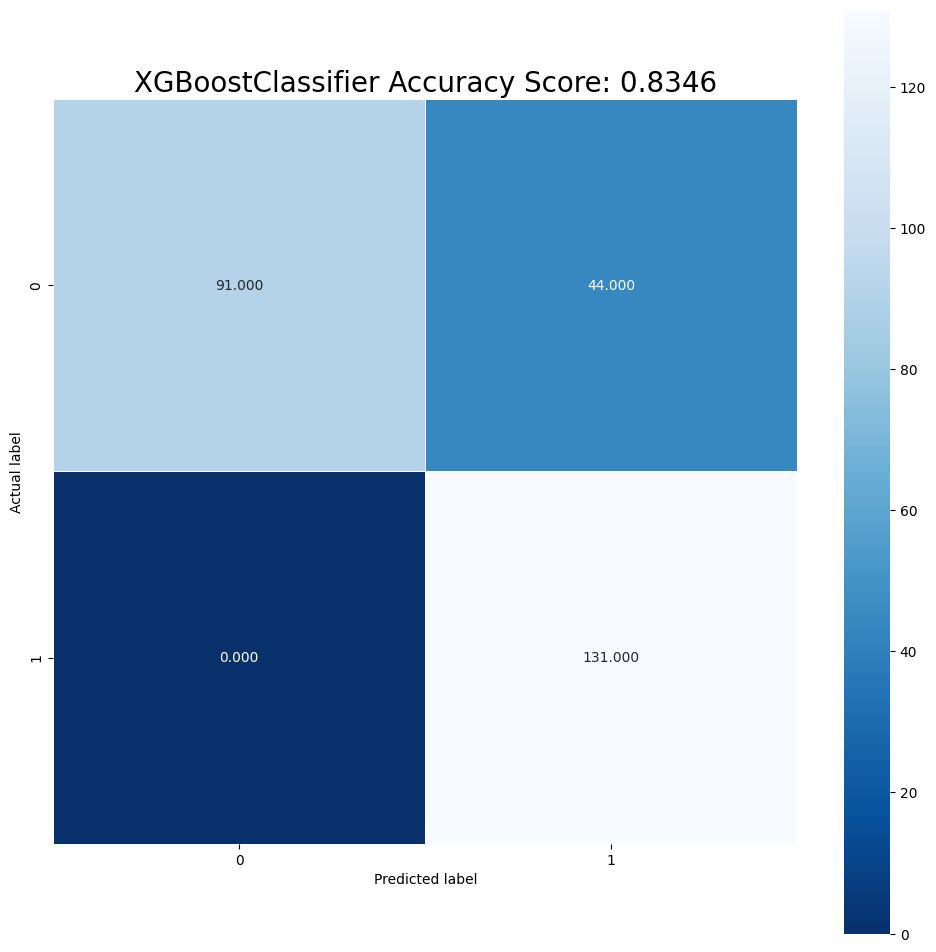

In [18]:
xgb_cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(xgb_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoostClassifier Accuracy Score: {0}'.format(round(accuracy,4))
plt.title(title, size = 20)
plt.savefig("cm_xgboost.png")

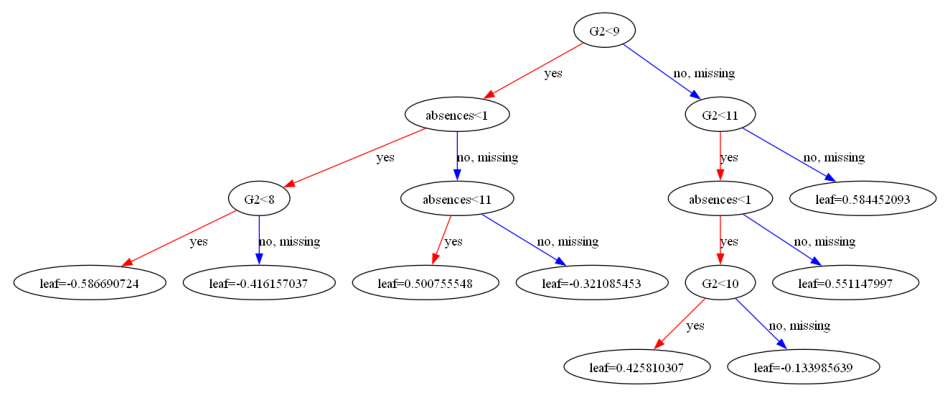

In [19]:
# Draw ID3 
fig, ax = plt.subplots(figsize=(12, 10))

plot_tree(xgb_model, num_trees=0, ax=ax)
plt.savefig('xgboost_tree.png', dpi=100)
plt.show()

In [20]:
booster = xgb_model.get_booster()

# Export xgboost tree to text
dumped_trees = booster.get_dump(with_stats=True)

# Save rule
with open('xgboost_rules.txt', 'w') as f:
    for i, tree in enumerate(dumped_trees):
        f.write(f"Tree {i}:\n")
        f.write(tree)
        f.write("\n\n")

In [21]:
# Create new data to predict
new_data = {
    'absences': 0,
    'G2': 3
}
new_data = pd.DataFrame([new_data])
# Prediction
predicted = xgb_model.predict(new_data)
print('Học sinh có đậu môn hay không:', 'Yes' if predicted == 1 else 'No')

Học sinh có đậu môn hay không: No
